In [1]:
import jax
import ml_collections
import numpy as np
from flax.training import checkpoints
from flax_model import (
    CNN_LST,
    CNN_LandCover,
    create_train_state,
)

In [32]:
CLASSIFICATIONS = {
    "water": "419BDF",
    "trees": "397D49",
    "grass": "88B053",
    "flooded vegetation": "7A87C6",
    "crops": "E49635",
    "shrub and scrub": "DFC35A",
    "built-up areas": "C4281B",
    "bare ground": "A59B8F",
    "snow and ice": "B39FE1",
}

In [35]:
model_lc = CNN_LandCover()
config = ml_collections.ConfigDict()

config.learning_rate = 0.001
config.batch_size = 32
config.img_size = 128
config.num_epochs = 250
config.train_test_split = 0.9

rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
init_state = create_train_state(init_rng, config, "lc")
pytree = {"model": init_state}

In [36]:
state = checkpoints.restore_checkpoint(
    "../models/flax/lc/checkpoints/249", target=init_state
)

In [37]:
input = np.load("../models/flax/lc/train/epoch_100/lc/images.npy")
print(input.shape)

(1814, 128, 128, 3)


In [39]:
label = np.load("../models/flax/lc/train/epoch_100/lc/labels.npy")
print(label.shape)

(1814, 128, 128, 1)


In [40]:
pred = np.load("../models/flax/lc/train/epoch_100/lc/preds.npy")
print(pred.shape)

(1814, 128, 128, 9)


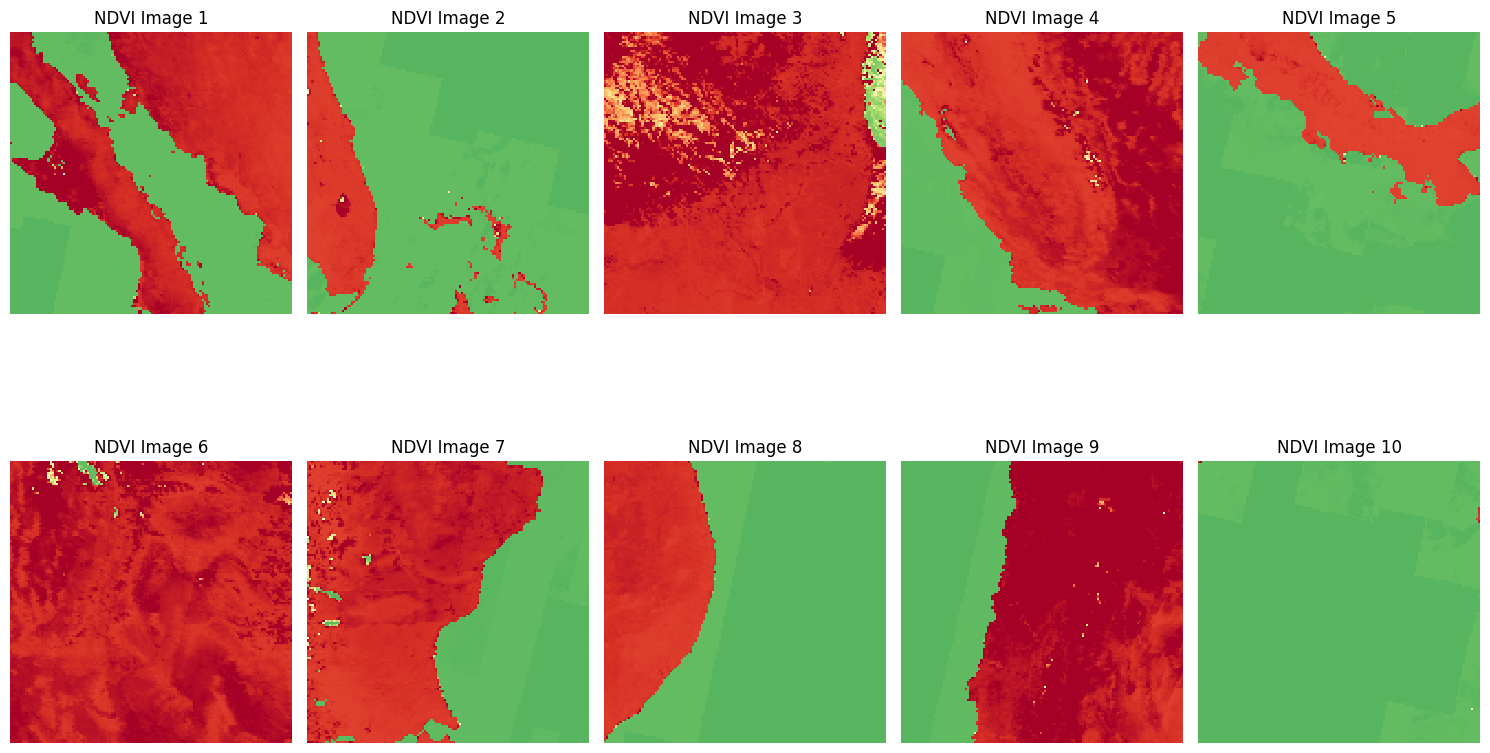

In [41]:
import matplotlib.pyplot as plt


def render_ndvi_as_rgb(
    ndvi: np.ndarray, min_val: float = -1, max_val: float = 1
) -> np.ndarray:
    """Converts an NDVI array into an RGB image using a colormap.

    Args:
        ndvi: A float array with NDVI values ranging from -1 to 1.
        min_val: The minimum value for normalization (default -1 for NDVI).
        max_val: The maximum value for normalization (default 1 for NDVI).

    Returns:
        A uint8 array with shape (width, height, rgb) representing RGB values.
    """
    # Normalize NDVI to the 0-1 range based on its theoretical min/max values of -1 to 1
    ndvi_normalized = (ndvi - min_val) / (max_val - min_val)
    # Apply a colormap (e.g., 'viridis' for continuous data, 'RdYlGn' for diverging color mapping more suitable for NDVI)
    colormap = plt.get_cmap("RdYlGn")
    ndvi_rgb = colormap(ndvi_normalized)  # This returns RGBA where A is alpha (opacity)
    # Convert RGBA to RGB by ignoring the alpha channel and multiplying by 255 for uint8
    ndvi_rgb = (ndvi_rgb[..., :3] * 255).astype(np.uint8)
    return ndvi_rgb


def show_inputs(inputs: np.ndarray, num_images: int = 10) -> None:
    """Shows the first 'num_images' NDVI data as RGB images using matplotlib."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, inputs.shape[0])):
        ndvi_image = inputs[i, :, :, 0]  # Assuming the NDVI is in the first channel
        rgb_image = render_ndvi_as_rgb(ndvi_image)
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(rgb_image, interpolation="nearest")
        ax.set_title(f"NDVI Image {i+1}")
        ax.axis("off")  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()


# Example usage:
# Assuming 'input_images' is a batch of images and you want to visualize the first 10
show_inputs(input)

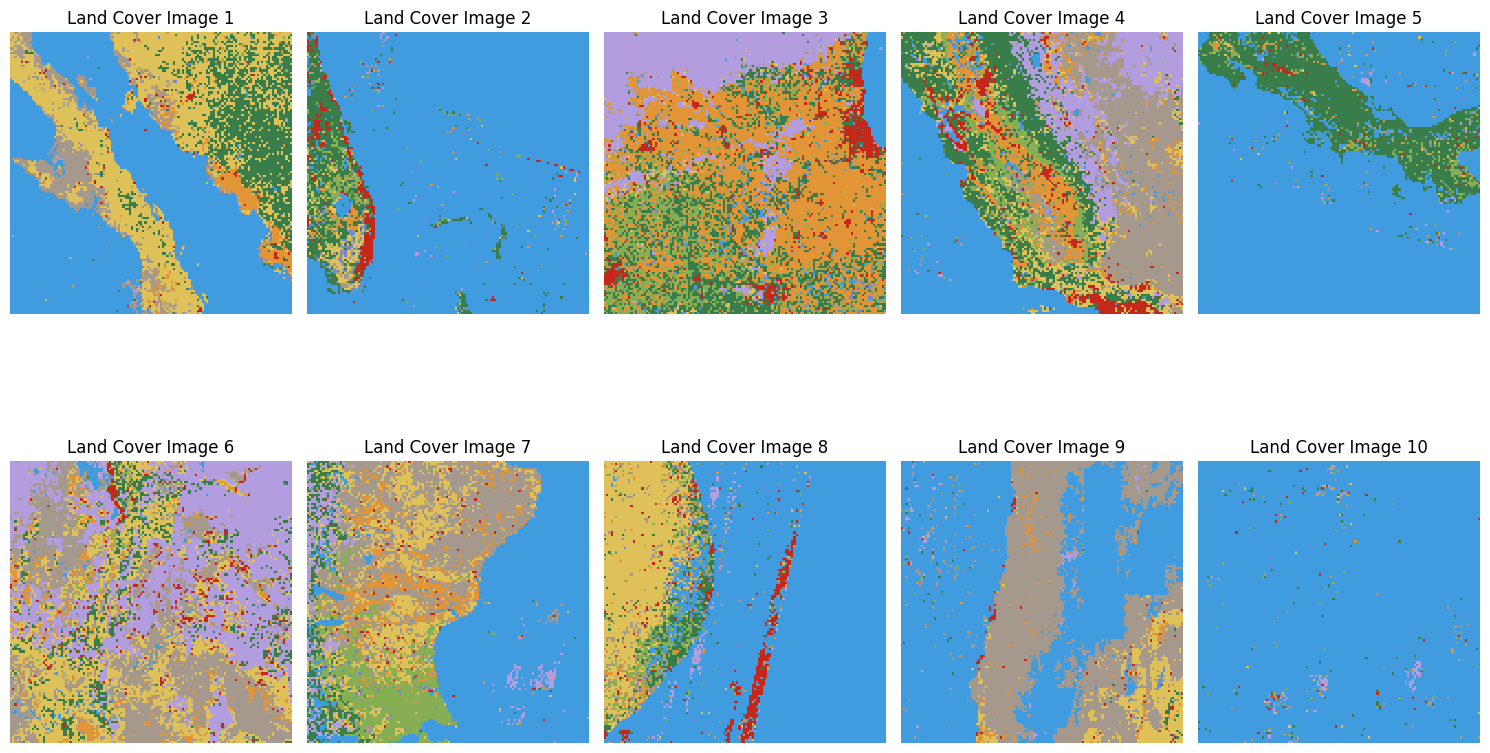

In [42]:
def render_classifications(values: np.ndarray, palette: list[str]) -> np.ndarray:
    """Renders a classifications NumPy array with shape (width, height) as an RGB image.

    Args:
        values: An uint8 array with shape (width, height).
        palette: List of hex encoded colors.

    Returns: An uint8 array with shape (width, height, rgb) with colors from the palette.
    """
    # Prepare the color map array
    xs = np.linspace(0, len(palette), 256)
    indices = np.arange(len(palette))

    red = np.interp(xs, indices, [int(c[0:2], 16) for c in palette])
    green = np.interp(xs, indices, [int(c[2:4], 16) for c in palette])
    blue = np.interp(xs, indices, [int(c[4:6], 16) for c in palette])

    color_map = np.array([red, green, blue]).astype(np.uint8).transpose()
    color_indices = (values / len(palette) * 255).astype(np.uint8)
    return np.take(color_map, color_indices, axis=0)


def render_landcover(patch: np.ndarray, pred: bool = False) -> np.ndarray:
    """Renders a land cover image."""
    if pred:
        patch = patch.argmax(-1)
    else:
        patch = patch.squeeze()
    palette = list(CLASSIFICATIONS.values())
    return render_classifications(
        patch, palette
    )  # Ensure patch is squeezed in case it has an extra dimension


def show_outputs(outputs: np.ndarray, num_images: int = 10) -> None:
    """Shows the first 'num_images' land cover output data as images using matplotlib."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, outputs.shape[0])):
        landcover_image = render_landcover(outputs[i])
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(landcover_image, interpolation="nearest")
        ax.set_title(f"Land Cover Image {i+1}")
        ax.axis("off")  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()


def show_predictions(preds: np.ndarray, num_images: int = 10) -> None:
    """Shows the first 'num_images' land cover output data as images using matplotlib."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, preds.shape[0])):
        landcover_image = render_landcover(preds[i], pred=True)
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(landcover_image, interpolation="nearest")
        ax.set_title(f"Land Cover Image {i+1}")
        ax.axis("off")  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()


show_outputs(label)

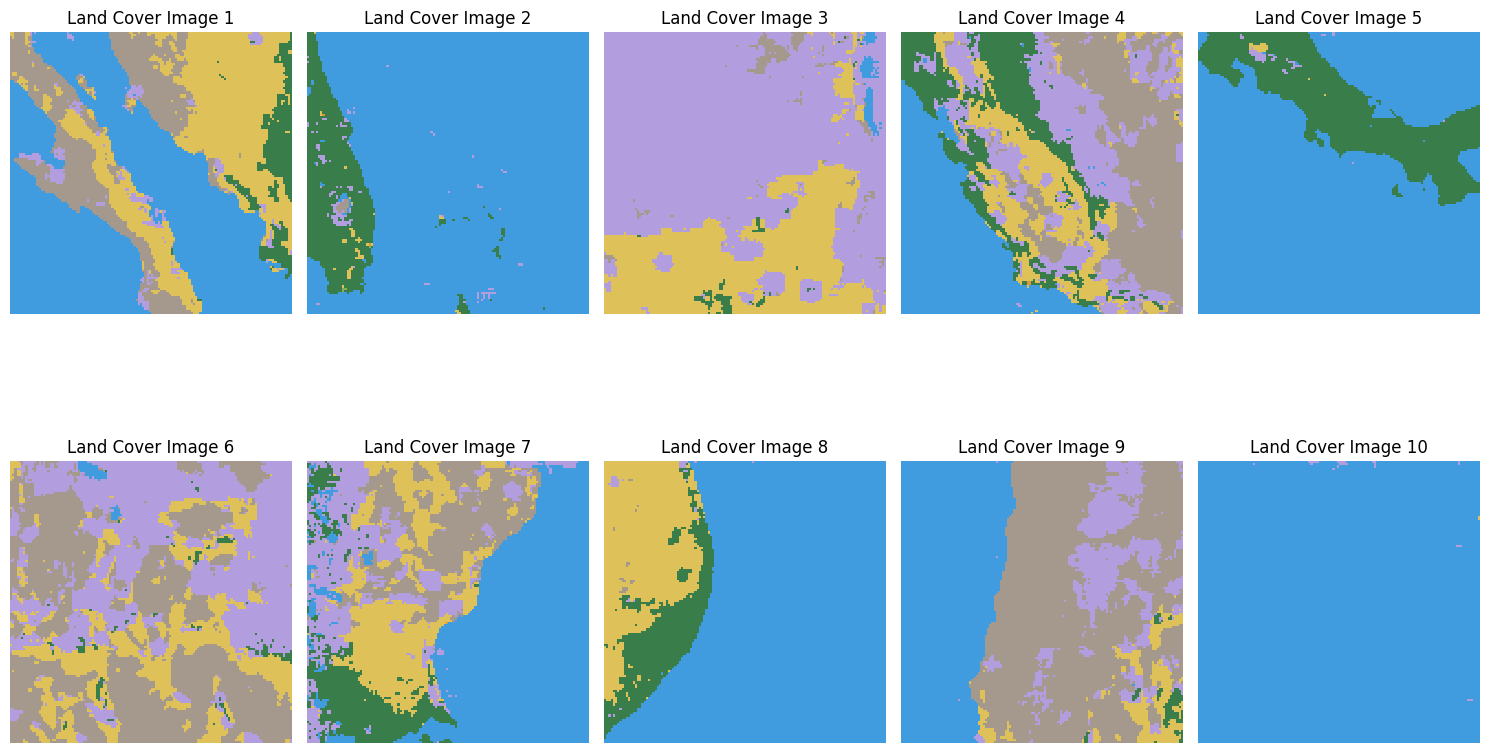

In [43]:
show_predictions(pred)

In [54]:
output = model_lc.apply({"params": lc_params["model"].params}, input[:10])

output.shape

(10, 128, 128, 9)

In [55]:
print(output[0])

[[[ 2.55647421e-01  5.50006390e-01 -2.70707965e-01 ... -2.99433112e-01
    1.65069962e+00  1.64955807e+00]
  [ 2.18763396e-01  3.23768497e-01 -6.75433099e-01 ... -9.24694538e-03
    2.45352340e+00  1.53904605e+00]
  [ 5.39631069e-01  4.75273222e-01 -6.43104851e-01 ...  1.38223648e-01
    3.06060910e+00  1.83348036e+00]
  ...
  [-6.03459716e-01  4.59530264e-01 -7.22594187e-03 ... -1.45678723e+00
   -5.89168310e-01  5.89543760e-01]
  [-1.07152033e+00  2.95002401e-01  9.81898531e-02 ... -2.33808780e+00
   -2.40499735e+00  2.11876333e-02]
  [-1.07105482e+00  3.93712044e-01  2.72779800e-02 ... -2.37436557e+00
   -2.56543541e+00 -1.15062773e-01]]

 [[ 8.33910227e-01  7.80267477e-01  1.40703797e-01 ...  4.16981459e-01
    2.86414027e+00  2.14122891e+00]
  [ 1.45791724e-01  6.20985568e-01 -6.24207318e-01 ...  6.47473335e-03
    2.59860206e+00  1.41601646e+00]
  [ 2.81031787e-01  4.91830945e-01 -4.87915844e-01 ...  3.93869996e-01
    3.60318923e+00  1.81521797e+00]
  ...
  [-4.99921560e-01  5.9

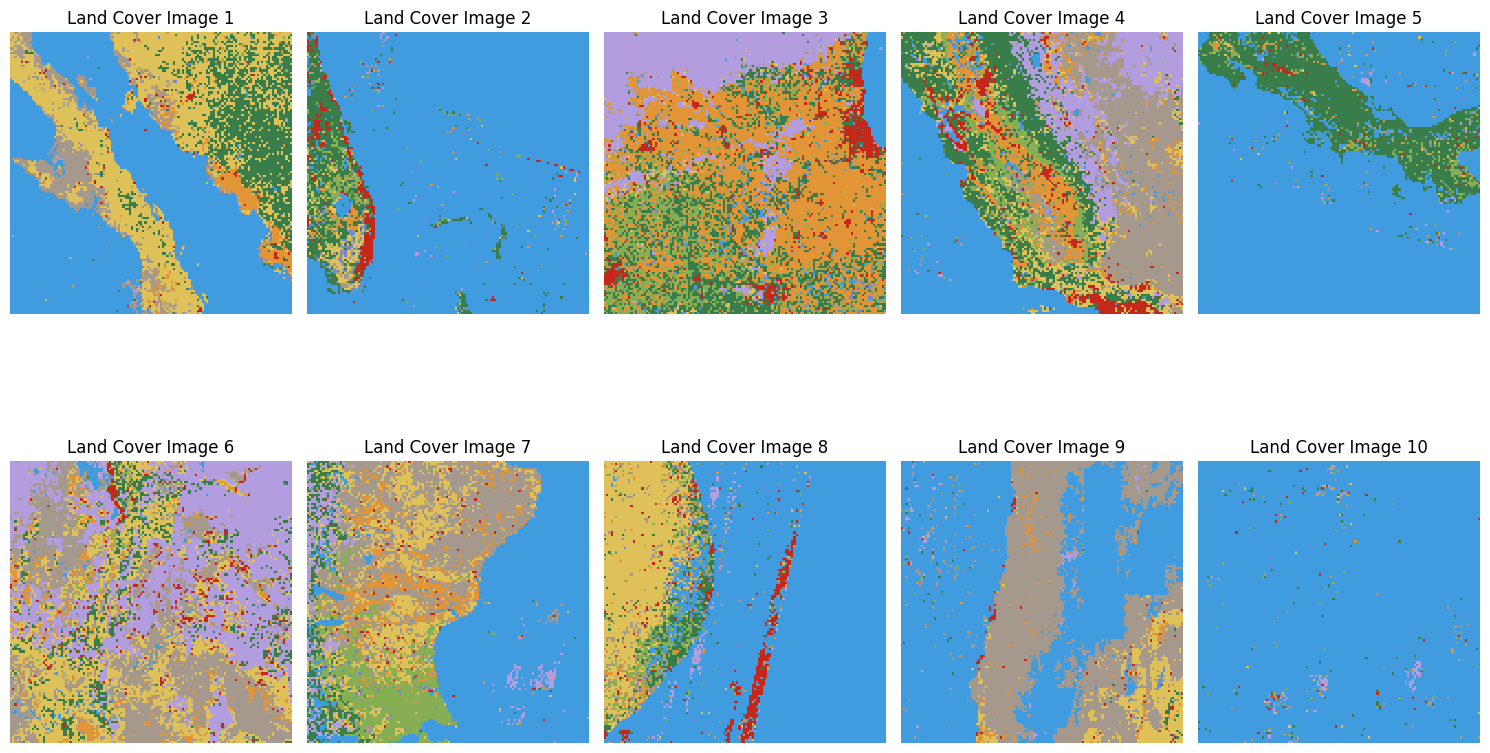

In [56]:
show_outputs(label[:10])

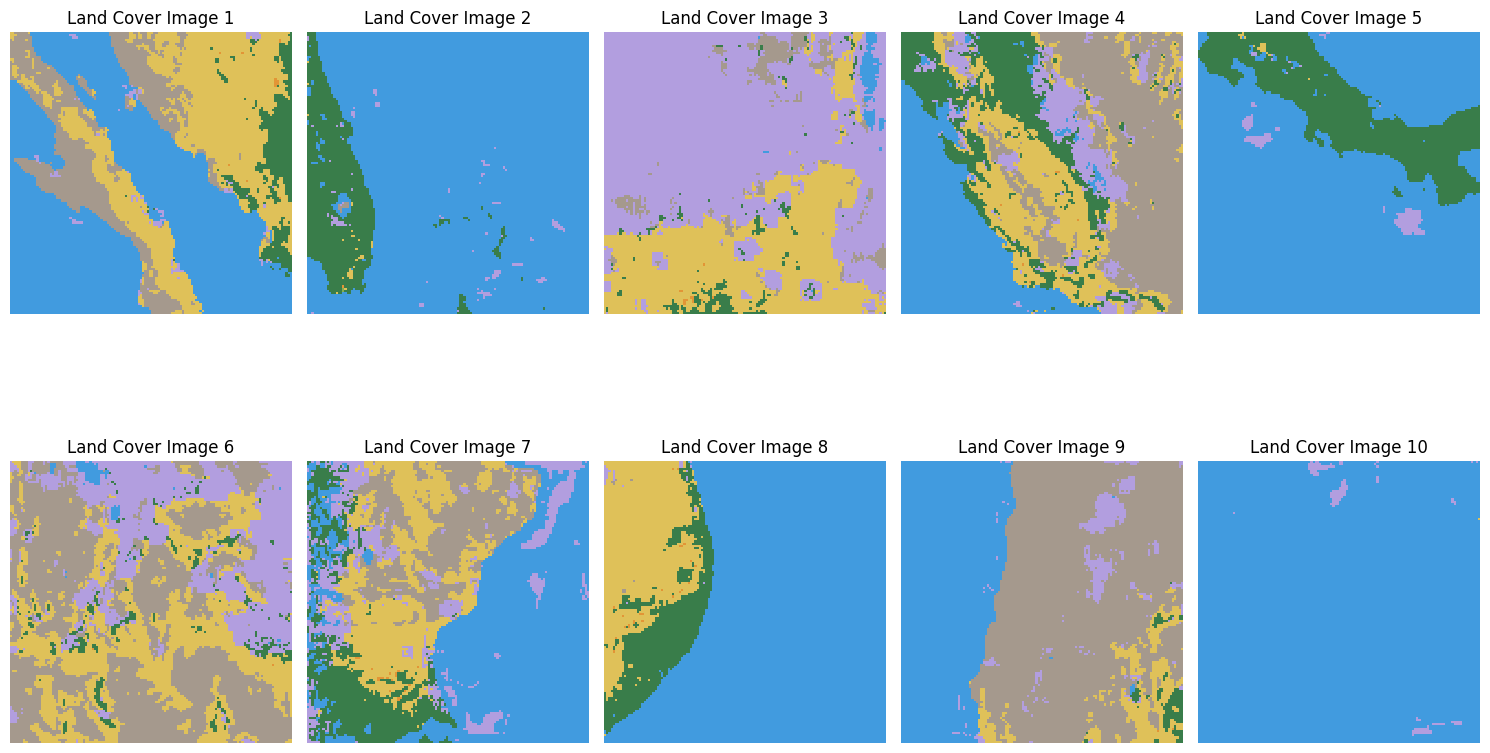

In [57]:
show_predictions(output)

In [58]:
input = np.load("../models/flax/lst/test/epoch_140/lst/images.npy")
print(input.shape)

(1814, 128, 128, 3)


In [59]:
output = np.load("../models/flax/lst/test/epoch_140/lst/labels.npy")
print(output.shape)

(1814, 128, 128, 1)


In [60]:
pred = np.load("../models/flax/lst/test/epoch_140/lst/preds.npy")
print(pred.shape)

(1814, 128, 128, 1)


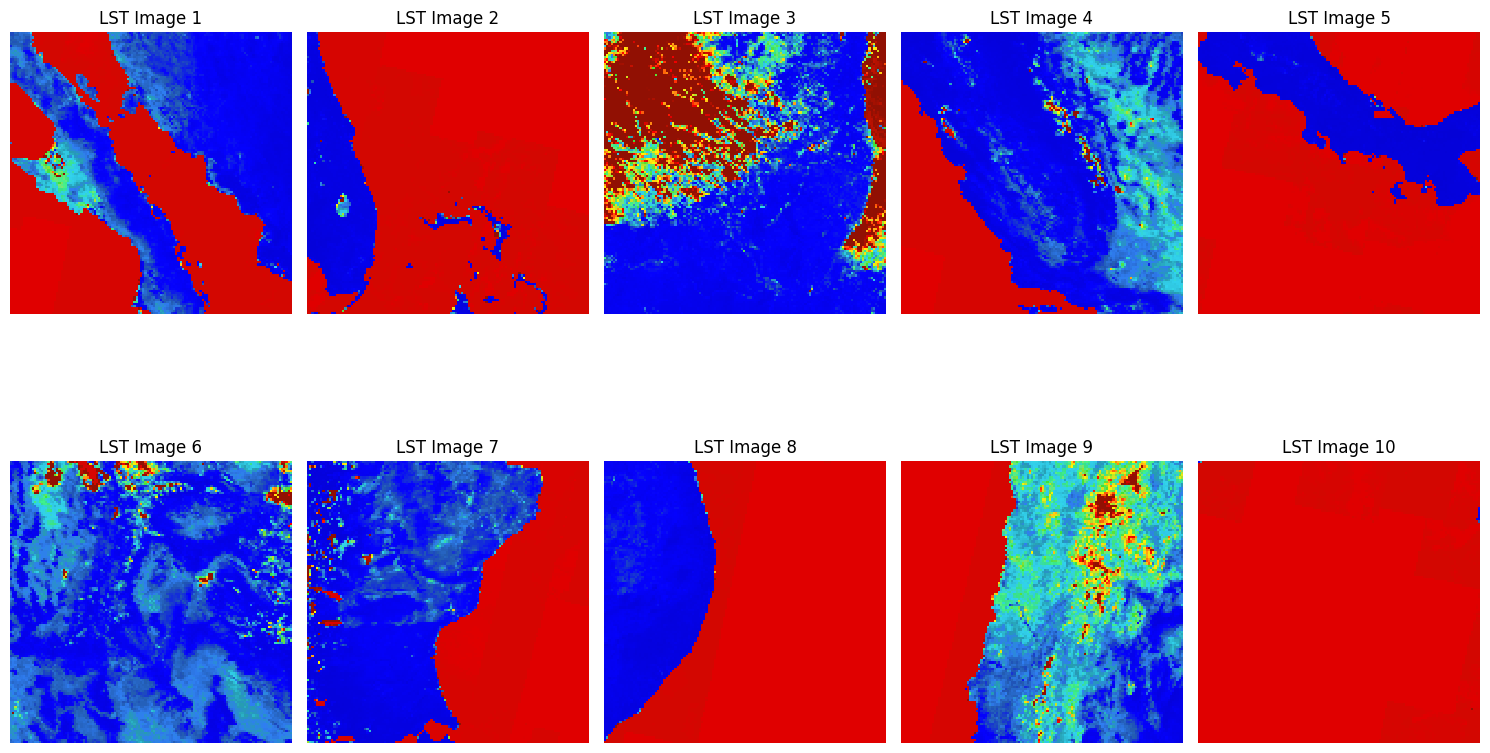

In [61]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


def render_lst_as_rgb(
    lst: np.ndarray, min_val: float, max_val: float, palette: list[str]
) -> np.ndarray:
    """Converts LST array into an RGB image using a colormap from a list of hex colors.

    Args:
        lst: A float array with LST values.
        min_val: Minimum value of LST for normalization.
        max_val: Maximum value of LST for normalization.
        palette: List of hex encoded colors used for the colormap.

    Returns:
        An RGB image array rendered based on LST values.
    """
    # Normalize the LST values to the range [0, 1]
    normalized_lst = (lst - min_val) / (max_val - min_val)
    normalized_lst = np.clip(
        normalized_lst, 0, 1
    )  # Ensure all values are within [0, 1]

    # Create a color map from the given hex palette
    colors = [
        (int(c[:2], 16) / 255, int(c[2:4], 16) / 255, int(c[4:], 16) / 255)
        for c in palette
    ]
    colormap = LinearSegmentedColormap.from_list("custom_lst", colors, N=256)

    # Map normalized data to colors
    rgb_image = colormap(normalized_lst)

    return (rgb_image[:, :, :3] * 255).astype(np.uint8)  # Return as uint8


def show_lst_inputs(
    inputs: np.ndarray,
    num_images: int = 10,
    min_val: float = 273.15,
    max_val: float = 273.15 + 42.86,
):
    """Displays a grid of LST input images using a specific color scale."""
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    for i in range(min(num_images, inputs.shape[0])):
        lst_image = inputs[i, :, :, -1]  # Assuming the LST is in the last channel
        rgb_image = render_lst_as_rgb(
            lst_image,
            min_val,
            max_val,
            [
                "040274",
                "040281",
                "0502a3",
                "0502b8",
                "0502ce",
                "0502e6",
                "0602ff",
                "235cb1",
                "307ef3",
                "269db1",
                "30c8e2",
                "32d3ef",
                "3be285",
                "3ff38f",
                "86e26f",
                "3ae237",
                "b5e22e",
                "d6e21f",
                "fff705",
                "ffd611",
                "ffb613",
                "ff8b13",
                "ff6e08",
                "ff500d",
                "ff0000",
                "de0101",
                "c21301",
                "a71001",
                "911003",
            ],
        )
        ax = plt.subplot(2, 5, i + 1)  # Adjust the grid size as needed
        ax.imshow(rgb_image, interpolation="nearest")
        ax.set_title(f"LST Image {i+1}")
        ax.axis("off")  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()


show_lst_inputs(input, 10, -1, 1)

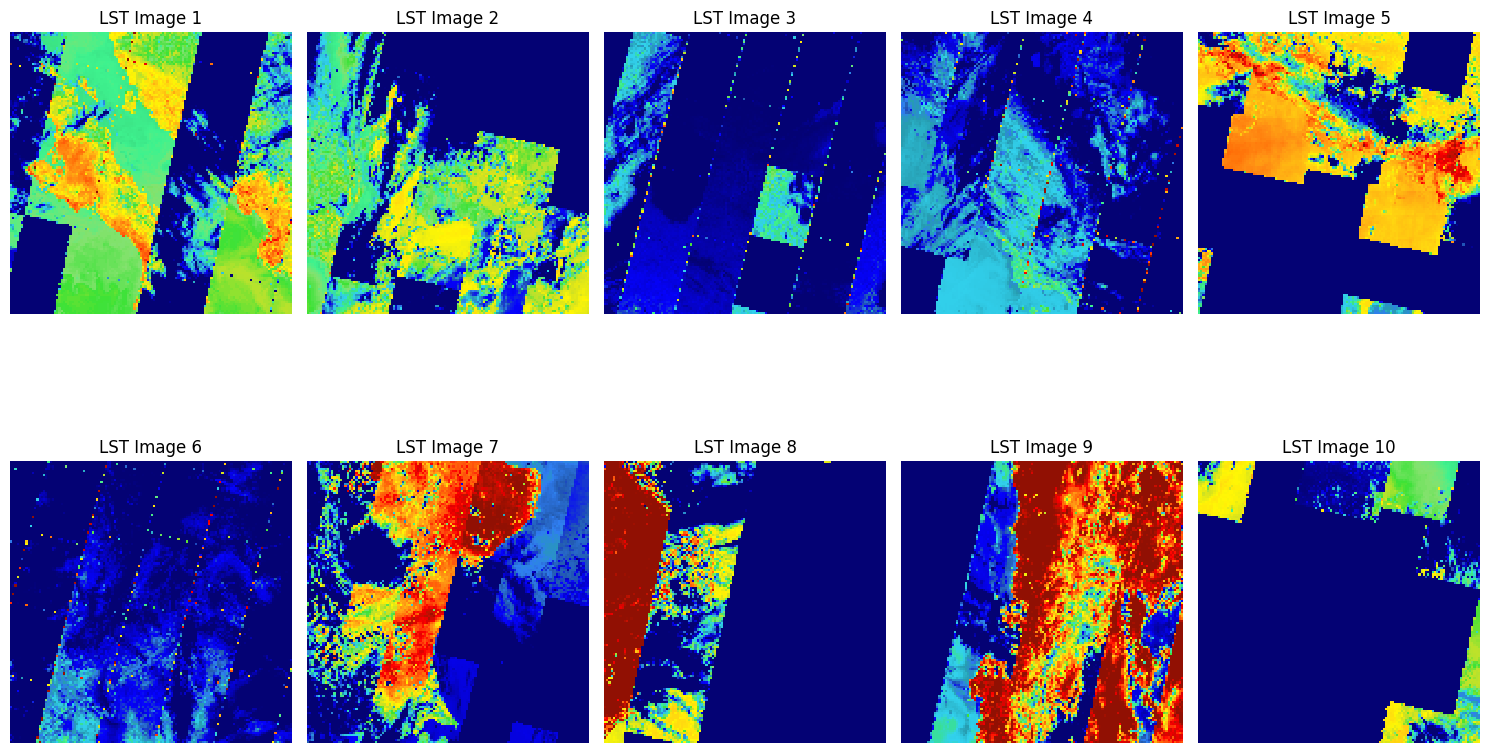

In [62]:
show_lst_inputs(output[:10], 10)

In [63]:
model = CNN_LST()
config = ml_collections.ConfigDict()

config.learning_rate = 0.001
config.batch_size = 8
config.img_size = 128
config.num_epochs = 250
config.train_test_split = 0.9

rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
init_state = create_train_state(init_rng, config, "lst")
pytree = {"model": init_state}

In [64]:
state = checkpoints.restore_checkpoint("../models/flax/lst/checkpoints/249", target=init_state)

In [65]:
prediction = model.apply({"params": state.params}, input[:10])

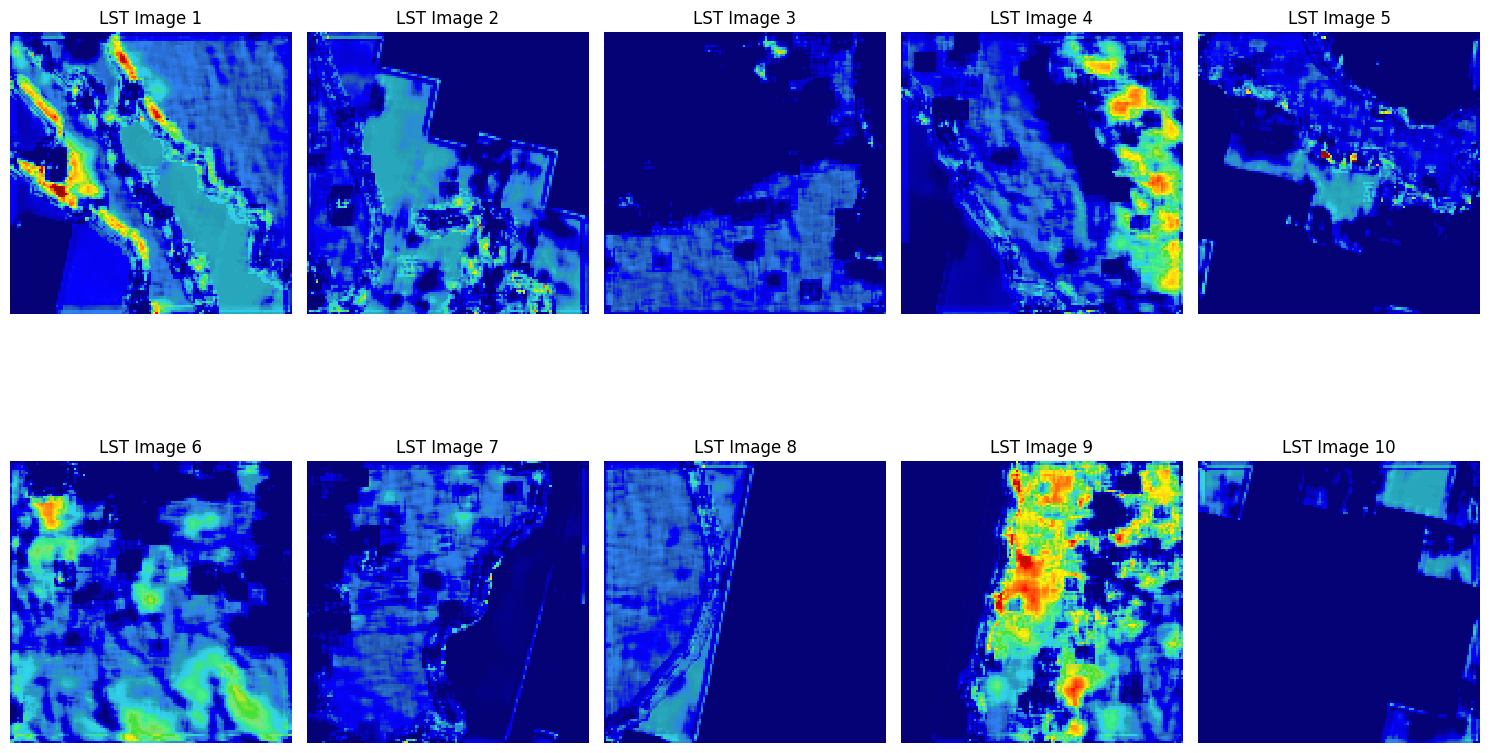

In [66]:
show_lst_inputs(prediction, 10)